# Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

import torch
import torchvision 
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# Loading The Data

In [2]:
# Hyperparameters
learning_rate = 0.01
batch_size = 64
num_epochs = 20

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)

train_size = int(0.8 * len(mnist_dataset))
val_size = len(mnist_dataset) - train_size
train_dataset, val_dataset = random_split(mnist_dataset, [train_size, val_size])

test_dataset = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:09<00:00, 1008124.25it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 158832.11it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1504985.81it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2350756.26it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Checking Unbalance In The Classes

In [4]:
labels = [label for _, label in mnist_dataset]

class_counts = Counter(labels)

sorted_class_counts = sorted(class_counts.items())

for digit, count in sorted_class_counts:
    print(f"Class {digit}: {count} images")

Class 0: 5923 images
Class 1: 6742 images
Class 2: 5958 images
Class 3: 6131 images
Class 4: 5842 images
Class 5: 5421 images
Class 6: 5918 images
Class 7: 6265 images
Class 8: 5851 images
Class 9: 5949 images


## Visualize A Batch Of Training Data

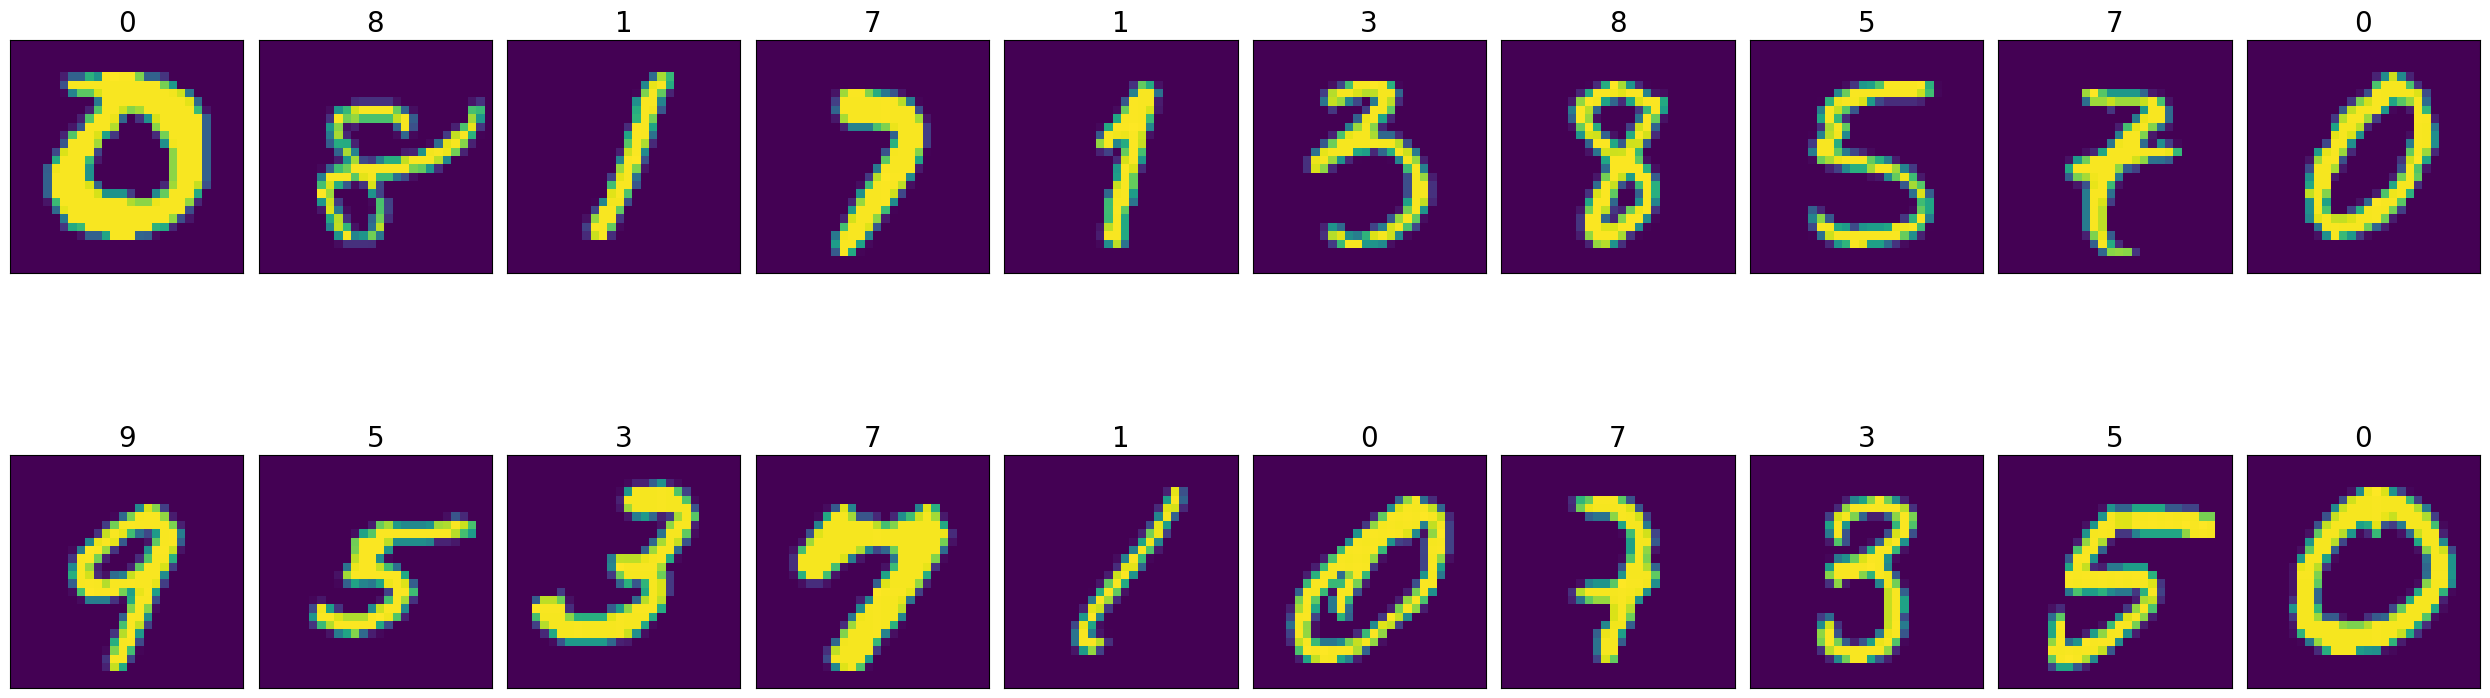

In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize = (25, 10))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
    image = np.transpose(images[idx], (1, 2, 0))
    ax.imshow(image)
    ax.set_title(str(labels[idx].item()), fontsize = 20)

plt.tight_layout()
plt.show()

# Building The Network

In [16]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 10)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr = 0.1,
    steps_per_epoch = len(train_loader),
    epochs = num_epochs
)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training The Model

In [18]:
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data, targets in tqdm(train_loader):
        data = data.to(device = device)
        targets = targets.to(device = device)

        scores = model(data)
        loss = criterion(scores, targets)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device = device)
            targets = targets.to(device = device)

            scores = model(data)
            loss = criterion(scores, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch: {epoch + 1}, Training Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}')
    
    scheduler.step()

100%|██████████| 750/750 [00:11<00:00, 64.97it/s]


Epoch: 1, Training Loss: 0.701654, Validation Loss: 0.306791


100%|██████████| 750/750 [00:11<00:00, 66.78it/s]


Epoch: 2, Training Loss: 0.441735, Validation Loss: 0.236928


100%|██████████| 750/750 [00:11<00:00, 66.16it/s]


Epoch: 3, Training Loss: 0.385447, Validation Loss: 0.228501


100%|██████████| 750/750 [00:11<00:00, 65.86it/s]


Epoch: 4, Training Loss: 0.360589, Validation Loss: 0.213035


100%|██████████| 750/750 [00:11<00:00, 64.15it/s]


Epoch: 5, Training Loss: 0.342183, Validation Loss: 0.200577


100%|██████████| 750/750 [00:11<00:00, 62.97it/s]


Epoch: 6, Training Loss: 0.337675, Validation Loss: 0.206317


100%|██████████| 750/750 [00:11<00:00, 63.83it/s]


Epoch: 7, Training Loss: 0.340034, Validation Loss: 0.241038


100%|██████████| 750/750 [00:11<00:00, 62.68it/s]


Epoch: 8, Training Loss: 0.324136, Validation Loss: 0.208430


100%|██████████| 750/750 [00:11<00:00, 63.55it/s]


Epoch: 9, Training Loss: 0.318571, Validation Loss: 0.204163


100%|██████████| 750/750 [00:11<00:00, 63.29it/s]


Epoch: 10, Training Loss: 0.306243, Validation Loss: 0.196324


100%|██████████| 750/750 [00:11<00:00, 64.87it/s]


Epoch: 11, Training Loss: 0.312668, Validation Loss: 0.198657


100%|██████████| 750/750 [00:11<00:00, 64.21it/s]


Epoch: 12, Training Loss: 0.296404, Validation Loss: 0.178196


100%|██████████| 750/750 [00:11<00:00, 65.76it/s]


Epoch: 13, Training Loss: 0.302305, Validation Loss: 0.189218


100%|██████████| 750/750 [00:11<00:00, 65.46it/s]


Epoch: 14, Training Loss: 0.292837, Validation Loss: 0.193571


100%|██████████| 750/750 [00:11<00:00, 64.82it/s]


Epoch: 15, Training Loss: 0.296262, Validation Loss: 0.171023


100%|██████████| 750/750 [00:11<00:00, 65.77it/s]


Epoch: 16, Training Loss: 0.289188, Validation Loss: 0.169110


100%|██████████| 750/750 [00:11<00:00, 65.30it/s]


Epoch: 17, Training Loss: 0.288266, Validation Loss: 0.179559


100%|██████████| 750/750 [00:11<00:00, 64.92it/s]


Epoch: 18, Training Loss: 0.278278, Validation Loss: 0.213694


100%|██████████| 750/750 [00:11<00:00, 64.83it/s]


Epoch: 19, Training Loss: 0.291794, Validation Loss: 0.191605


100%|██████████| 750/750 [00:11<00:00, 65.49it/s]


Epoch: 20, Training Loss: 0.285843, Validation Loss: 0.172428


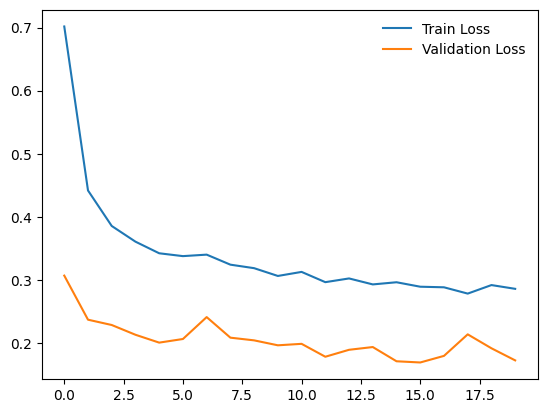

In [19]:
plt.plot(train_losses, label = 'Train Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.legend(frameon = False)

# Testing The Model

In [20]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device = device)
            y = y.to(device = device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return num_correct/num_samples


print(f"Accuracy on Training set: {check_accuracy(train_loader, model) * 100:.2f}%")
print(f"Accuracy on Test set: {check_accuracy(test_loader, model) * 100:.2f}%")

Accuracy on Training set: 95.81%
Accuracy on Test set: 95.11%


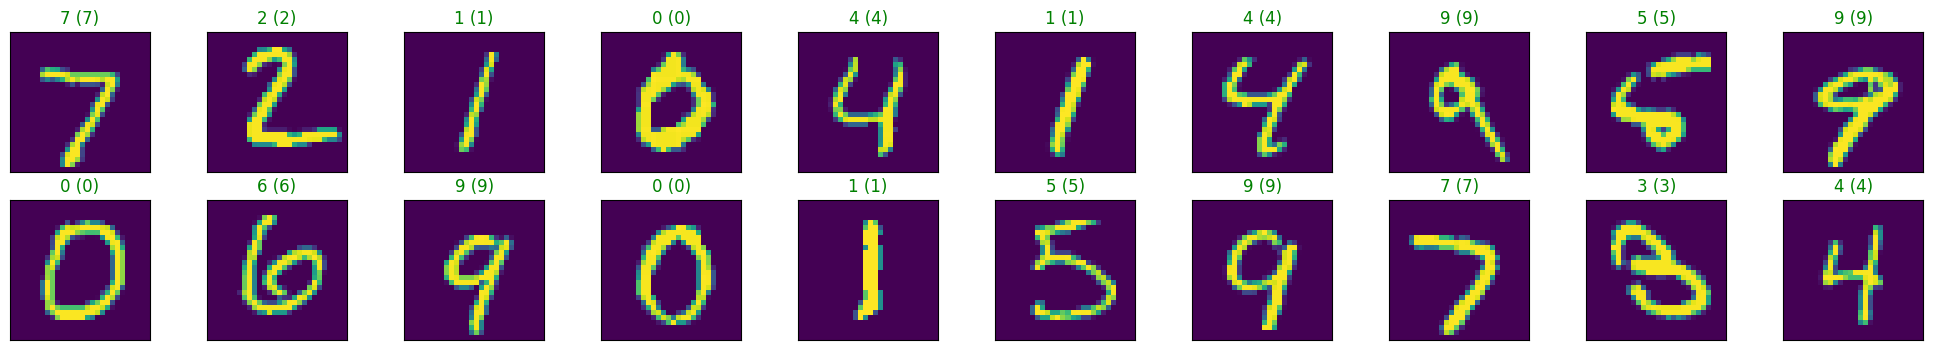

In [28]:
dataiter = iter(test_loader)
data, targets = next(dataiter)

data, targets = data.to(device), targets.to(device)

output = model(data)

_, preds = torch.max(output, 1)

data = data.cpu().numpy()
targets = targets.cpu().numpy()
preds = preds.cpu().numpy()

data = data.squeeze()

fig = plt.figure(figsize = (25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
    ax.imshow(data[idx])
    ax.set_title("{} ({})".format(str(preds[idx]), str(targets[idx])),
                 color=("green" if preds[idx] == targets[idx] else "red"))
plt.show()